## Importing libraries and defining necessary functions

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l1, l2
from PIL import Image, ImageEnhance, ImageOps

In [2]:
def enhance_contrast_and_threshold(img, threshold=128):
    # Enhance contrast
    enhancer = ImageEnhance.Contrast(img)
    enhanced_img = enhancer.enhance(3.0)  # Adjust the factor as needed

    # Convert to grayscale and apply binary threshold
    bw = ImageOps.grayscale(enhanced_img)
    bw = bw.point(lambda p: p > threshold and 255)

    return bw

# Importing the Dataset

In [3]:
# Set the path to the root directory
root_path = r"C:\Users\ezgi\Desktop\'23-'24 fall\deep learning\term project\data"
images = []
labels = []

valid_extensions = {".jpg", ".jpeg", ".png"}

for cam_folder in os.listdir(root_path):
    cam_folder_path= os.path.join(root_path, cam_folder)
    for folder_name in os.listdir(cam_folder_path):
        folder_path = os.path.join(cam_folder_path, folder_name)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if any(file_name.lower().endswith(ext) for ext in valid_extensions):
                    image_path = os.path.join(folder_path, file_name)
                    # Extract label from the file name (the label is the second part split by underscores)
                    label = file_name.split('_')[1]
                    
                    # Load the image using PIL
                    pil_image = Image.open(image_path)

                    # Enhance contrast and apply threshold
                    enhanced_image = enhance_contrast_and_threshold(pil_image)  # CONTRAST

                    # Convert PIL image to NumPy array
                    img = np.array(enhanced_image)

                    if img is None:
                        print(f"Failed to load image: {image_path}")
                    else:
                        img = cv2.resize(img, (64, 64))  # Resize the image to a consistent size
                        images.append(img)
                        labels.append(label)


## Preprocessing

In [4]:
# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Reshape images for compatibility with Conv2D layer
images = images.reshape(images.shape + (1,))

print("Number of images:", len(images))  # Add this line
print("Number of labels:", len(labels))  # Add this line

# Encode labels into numerical format
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Normalize pixel values to be between 0 and 1
images = images / 255.0

Number of images: 21042
Number of labels: 21042


## Splitting the Dataset

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

# Fitting the Model

In [6]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Use softmax for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
527/527 [==============================] - 37s 67ms/step - loss: 3.3678 - accuracy: 0.1954 - val_loss: 2.5217 - val_accuracy: 0.3885
Epoch 2/10
527/527 [==============================] - 35s 67ms/step - loss: 2.0269 - accuracy: 0.5007 - val_loss: 1.9207 - val_accuracy: 0.5348
Epoch 3/10
527/527 [==============================] - 35s 67ms/step - loss: 1.5136 - accuracy: 0.6364 - val_loss: 1.6337 - val_accuracy: 0.6187
Epoch 4/10
527/527 [==============================] - 35s 67ms/step - loss: 1.2387 - accuracy: 0.7171 - val_loss: 1.4559 - val_accuracy: 0.6595
Epoch 5/10
527/527 [==============================] - 35s 67ms/step - loss: 1.0391 - accuracy: 0.7784 - val_loss: 1.3631 - val_accuracy: 0.6890
Epoch 6/10
527/527 [==============================] - 35s 67ms/step - loss: 0.9098 - accuracy: 0.8163 - val_loss: 1.3117 - val_accuracy: 0.7104
Epoch 7/10
527/527 [==============================] - 35s 67ms/step - loss: 0.7997 - accuracy: 0.8508 - val_loss: 1.2480 - val_accuracy:

# Results

In [8]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy * 100:.2f}%')

132/132 [==============================] - 2s 18ms/step - loss: 1.2183 - accuracy: 0.7439
Test loss: 1.2183, Test accuracy: 74.39%


### Plotting 5 random samples from test set

1/1 [==============================] - 0s 32ms/step


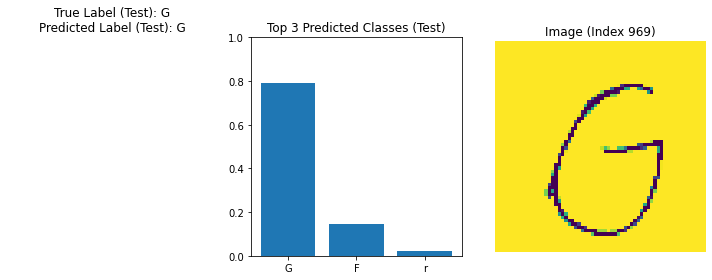

1/1 [==============================] - 0s 30ms/step


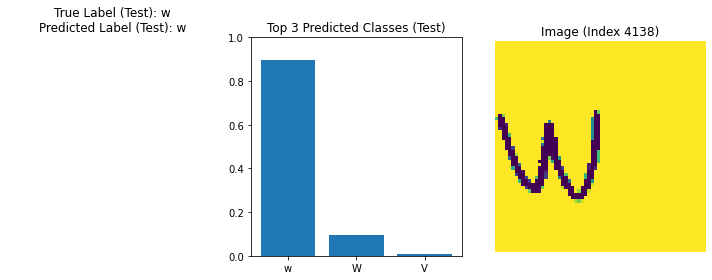

1/1 [==============================] - 0s 32ms/step


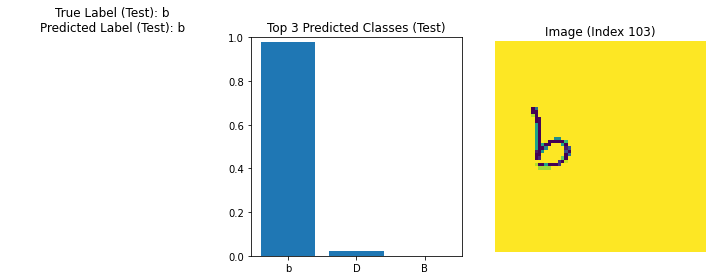

1/1 [==============================] - 0s 28ms/step


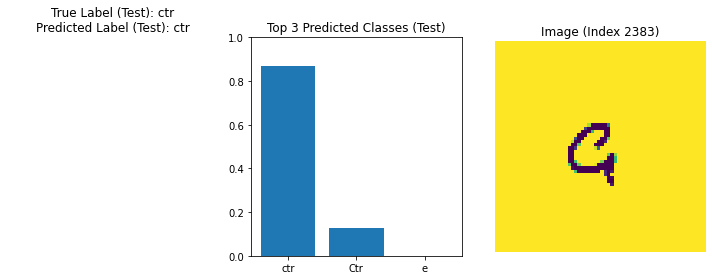

1/1 [==============================] - 0s 26ms/step


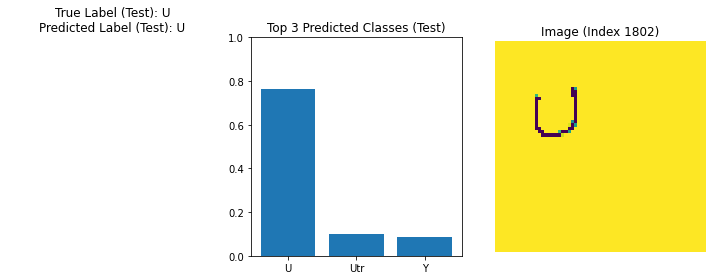

In [30]:
import matplotlib.pyplot as plt
import random

# Plot 5 random examples from the test set
for i in range(5):
    index_test = random.randint(0, len(X_test) - 1)

    # Make prediction on the selected sample from the test set
    prediction_test = model.predict(X_test[index_test:index_test+1])
    predicted_label_test = np.argmax(prediction_test)
    top_three_classes_test = np.argsort(prediction_test[0])[::-1][:3]
    top_three_probabilities_test = prediction_test[0][top_three_classes_test]

    # Display true label, predicted label, and the image itself
    plt.figure(figsize=(10, 4))

    # True label and predicted label
    plt.subplot(1, 3, 1)
    plt.title(f'True Label (Test): {label_encoder.classes_[y_test[index_test]]}\nPredicted Label (Test): {label_encoder.classes_[predicted_label_test]}')
    plt.axis('off')

    # Top three predicted classes and their probabilities (smaller size)
    plt.subplot(1, 3, 2)
    plt.bar(range(3), top_three_probabilities_test)
    plt.title('Top 3 Predicted Classes (Test)')
    plt.xticks(range(3), label_encoder.classes_[top_three_classes_test], rotation=0)
    plt.ylim(0, 1)  # Set the y-axis limit to 0-1 for probability values

    # Image
    plt.subplot(1, 3, 3)
    plt.title(f'Image (Index {index_test})')
    plt.imshow(X_test[index_test])
    plt.axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()


### Plotting 5 wrong predicted random samples from train set

Since the accuracy of the train set is high, we are plotting wrong predicted samples. Visualizing misclassifications can provide insights into potential patterns or challenges that the model is facing.

1/1 [==============================] - 0s 20ms/step


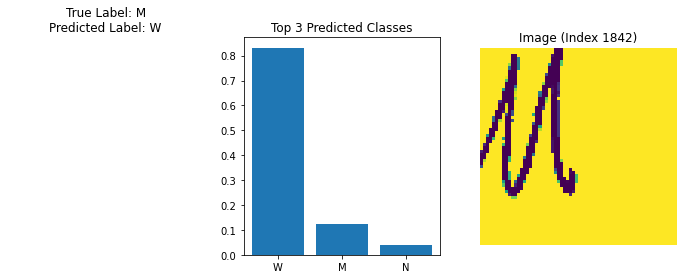

1/1 [==============================] - 0s 27ms/step


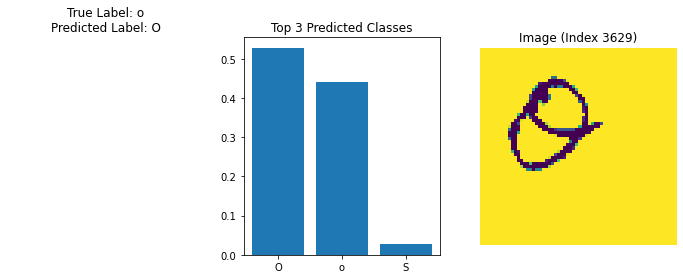

1/1 [==============================] - 0s 23ms/step


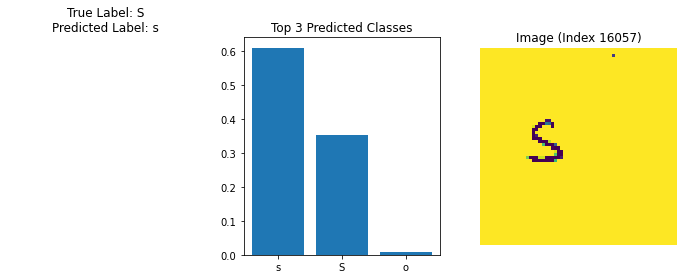

1/1 [==============================] - 0s 31ms/step


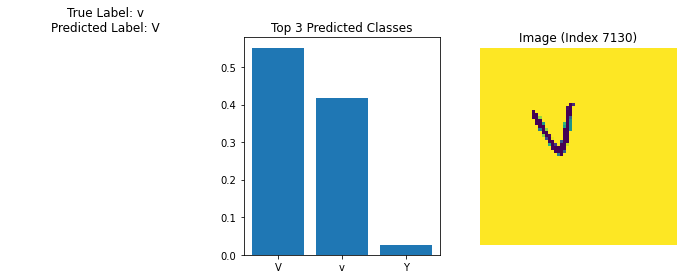

1/1 [==============================] - 0s 25ms/step


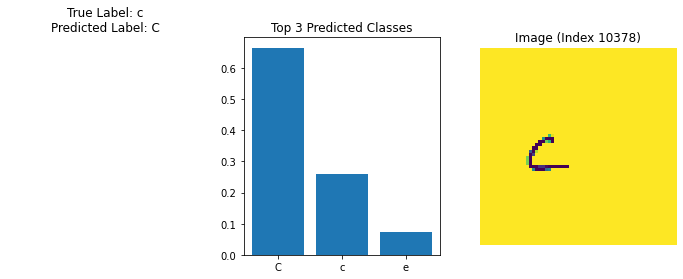

In [19]:
import matplotlib.pyplot as plt
import random

# Make predictions on the entire training set
predictions_train = model.predict(X_train)
predicted_labels_train = np.argmax(predictions_train, axis=1)

# Find indices of incorrectly predicted samples
incorrect_indices_train = np.where(predicted_labels_train != y_train)[0]

# Plot 5 random examples from the training set that were predicted wrong
for i in range(5):
    index_train = random.choice(incorrect_indices_train)

    # Make prediction on the selected sample from the training set
    prediction_train = model.predict(X_train[index_train:index_train+1])
    predicted_label_train = np.argmax(prediction_train)
    top_three_classes = np.argsort(prediction_train[0])[::-1][:3]
    top_three_probabilities = prediction_train[0][top_three_classes]

    # Display true label, predicted label, and the image itself
    plt.figure(figsize=(12, 4))

    # True label and predicted label
    plt.subplot(1, 3, 1)
    plt.title(f'True Label: {label_encoder.classes_[y_train[index_train]]}\nPredicted Label: {label_encoder.classes_[predicted_label_train]}')
    plt.axis('off')

    # Top three predicted classes and their probabilities
    plt.subplot(1, 3, 2)
    plt.bar(range(3), top_three_probabilities)
    plt.title('Top 3 Predicted Classes')
    plt.xticks(range(3), label_encoder.classes_[top_three_classes], rotation=0)

    # Image
    plt.subplot(1, 3, 3)
    plt.title(f'Image (Index {index_train})')
    plt.imshow(X_train[index_train])
    plt.axis('off')

    plt.show()
